In [14]:
# import libraries
import numpy as np
import csv
import torch
import torch.nn as nn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from models.LSTM import LSTM
from models.RNN import RNN
from models.GRU import GRU
from models.LSTM import LSTM
from models.transformer import TransformerClassifier
from torch.utils.data import DataLoader
from dataset import Dataset
import os
from torchsummary import summary
from tools.adjust_learning_rate import adjust_learning_rate
from tools.train import train
from tools.test import test
from torch.utils.tensorboard import SummaryWriter
import wandb
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
torch.manual_seed(42)



In [15]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load 3D numpy matrices (user, time, transaction type)
ns = np.load('data/neg_sequences.npy')
ps = np.load('data/pos_sequences.npy')

transaction_size = ns.shape[-1]

# Take a look at the given data with OHE (one-hot encodings)
print('Shape of negative sequence array (OHE): ', ns.shape)
print('Shape of positive sequence array (OHE): ', ps.shape)

# Convert one-hot encodings to integers:
ns = np.argmax(ns, axis=2)
ps = np.argmax(ps, axis=2)

# Take a look at the given data
print('Shape of negative sequence array: ', ns.shape)
print('Shape of positive sequence array: ', ps.shape)


Shape of negative sequence array (OHE):  (100000, 10, 312)
Shape of positive sequence array (OHE):  (11979, 10, 312)
Shape of negative sequence array:  (100000, 10)
Shape of positive sequence array:  (11979, 10)


In [16]:
# Label the data
ns_label = np.zeros_like(ns[:,0])
ps_label = np.ones_like(ps[:,0])

# Concetenate positive sequences with negative sequences regarding users with correponding labels (axis=0)
X = np.concatenate((ns, ps), axis=0)
y = np.concatenate((ns_label, ps_label), axis=0) 

# Shuffle data and labels, for reproductivity set random_state=0
# dataset, labels = shuffle(dataset, labels, random_state=42)

In [17]:
# Define train, test and validation ratios
train_ratio = 0.8
test_ratio = 0.1
val_ratio = 0.1

# Split the data / Shuffle it and maintain class balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_ratio, random_state=42, shuffle=True)

# Further split train_data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=val_ratio, random_state=42, shuffle=True)


In [18]:
# Print train, test and validation dataset and label shapes
print('X_train.shape: ', X_train.shape, ' - y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape, ' - y_test.shape: ', y_test.shape)
print('X_val.shape: ', X_val.shape, ' - y_val.shape: ', y_val.shape)

# Convert numpy arrays to torch.tensor
X_train, y_train = torch.from_numpy(X_train), torch.from_numpy(y_train)
X_train, y_train = X_train.to(device, dtype=torch.int32), y_train.to(device, dtype=torch.float32)
X_test, y_test = torch.from_numpy(X_test), torch.from_numpy(y_test)
X_test, y_test = X_test.to(device, dtype=torch.int32), y_test.to(device, dtype=torch.float32)
X_val, y_val = torch.from_numpy(X_val), torch.from_numpy(y_val)
X_val, y_val = X_val.to(device, dtype=torch.int32), y_val.to(device, dtype=torch.float32)

# Number of positive sequences in training data
num_pos_seq = torch.count_nonzero(y_train).view(1)
num_neg_seq = (y_train.shape[0] - num_pos_seq).view(1)
print('Training data -> num_pos_seq: ', num_pos_seq, ' num_neg_seq: ', num_neg_seq)

# Create a custom dataset
train_dataset = Dataset(X_train, y_train, device)
test_dataset = Dataset(X_test, y_test, device)
val_dataset = Dataset(X_val, y_val, device)


X_train.shape:  (90702, 10)  - y_train.shape:  (90702,)
X_test.shape:  (11198, 10)  - y_test.shape:  (11198,)
X_val.shape:  (10079, 10)  - y_val.shape:  (10079,)
Training data -> num_pos_seq:  tensor([9724], device='cuda:0')  num_neg_seq:  tensor([80978], device='cuda:0')


RNN-Classifier

In [19]:
# project_name = 'RNN-Classifier'

# # Initialize W&B for RNN-Classifier
# wandb.init(
#     # set the wandb project where this run will be logged
#     project = project_name,

#     # track hyperparameters and run metadata
#     config = dict(
#     project_name = project_name,
#     batch_size = 900,
#     transaction_size = transaction_size,
#     embedding_dim = 32,
#     hidden_dim = 64,
#     num_layers = 1,
#     device = device,
#     batch_first = True,
#     fc_hidden_dim = 64,
#     num_classes = 1,
#     num_epochs = 150,
#     learning_rate = 1e-4,
#     weight_decay = 0.0, 
#     lr_update_step = None,
#     log_step = 20,
#     lr_step_decay = False,
#     gamma = 0.95,
#     #pos_weight = num_neg_seq/num_pos_seq,
#     pos_weight = 6.0,
#     grad_clip = 1.0,
#     apply_grad_clip = False,
#     )
# )

# # initialize config
# config = wandb.config

# model = RNN(config.transaction_size, config.embedding_dim, config.hidden_dim, config.num_layers, config.device,
#             num_classes = config.num_classes, batch_first = config.batch_first, fc_hidden_dim = config.fc_hidden_dim)
# model.to(device)
# print(model)

GRU-Classifier

In [20]:
# project_name = 'GRU-Classifier'

# # Initialize W&B for GRU-Classifier
# wandb.init(
#     # set the wandb project where this run will be logged
#     project = project_name,

#     # track hyperparameters and run metadata
#     config = dict(
#     project_name = project_name,
#     batch_size = 900,
#     transaction_size = transaction_size,
#     embedding_dim = 32,
#     hidden_dim = 64,
#     num_layers = 1,
#     device = device,
#     batch_first = True,
#     fc_hidden_dim = 64,
#     num_classes = 1,
#     num_epochs = 25,
#     learning_rate = 1e-2,
#     weight_decay = 0.0, 
#     lr_update_step = None,
#     log_step = 20,
#     lr_step_decay = False,
#     gamma = 0.8,
#     pos_weight = num_neg_seq/num_pos_seq,
#     # pos_weight = 6.0,
#     grad_clip = 1.0,
#     apply_grad_clip = False,
#     )
# )

# # initialize config
# config = wandb.config

# model = GRU(config.transaction_size, config.embedding_dim, config.hidden_dim, config.num_layers, config.device,
#             num_classes = config.num_classes, batch_first = config.batch_first, fc_hidden_dim = config.fc_hidden_dim)
# model.to(device)
# print(model)

LSTM-Classifier

In [21]:
# project_name = 'LSTM-Classifier'

# # Initialize W&B for LSTM-Classifier
# wandb.init(
#     # set the wandb project where this run will be logged
#     project = project_name,

#     # track hyperparameters and run metadata
#     config= dict(
#     project_name = project_name,
#     batch_size = 900,
#     transaction_size = transaction_size,
#     embedding_dim = 64,
#     hidden_dim = 128,
#     num_layers = 5,
#     device = device,
#     batch_first = True,
#     fc_hidden_dim = 128,
#     num_classes = 1,
#     num_epochs = 25,
#     learning_rate = 1e-3,
#     weight_decay = 0.0, 
#     lr_update_step = None,
#     log_step = 10,
#     lr_step_decay = False,
#     gamma = 0.90,
#     pos_weight = num_neg_seq/num_pos_seq,
#     # pos_weight = 6.0,
#     grad_clip = 1.0,
#     apply_grad_clip = False,
#     )
# )

# # initialize config
# config = wandb.config

# model = LSTM(config.batch_size, config.transaction_size, config.embedding_dim, config.hidden_dim, config.num_layers, config.device,
#             num_classes = config.num_classes, batch_first = config.batch_first, fc_hidden_dim = config.fc_hidden_dim)
# model.to(device)
# print(model)


TRANSFORMER-Classifier

In [22]:
project_name = 'Transformer-Classifier'

# Initialize W&B for LSTM-Classifier
wandb.init(
    # set the wandb project where this run will be logged
    project = project_name,

    # track hyperparameters and run metadata
    config= dict(
    project_name = project_name,
    batch_size = 900,
    transaction_size = transaction_size,
    seq_len = 10,
    embedding_dim = 32,
    nhead = 8,
    dim_feedforward_encoder = 32,
    fc_hidden_dim = 32,
    dropout = 0.2,
    activation = "relu",
    batch_first = True,
    norm_first = True,
    bias = True,
    num_layers = 1,
    is_causal = False,
    learn_pos_embed = True,
    device = device,
    num_classes = 1,
    num_epochs = 25,
    learning_rate = 5e-4,
    weight_decay = 0.0, 
    lr_update_step = None,
    log_step = 10,
    lr_step_decay = False,
    gamma = 0.85,
    pos_weight = num_neg_seq/num_pos_seq,
    # pos_weight = 6.0,
    grad_clip = 1.0,
    apply_grad_clip = False,
    )
)

# initialize config
config = wandb.config

model = TransformerClassifier(transaction_size = config.transaction_size,
                              seq_len = config.seq_len,
                              embedding_dim = config.embedding_dim,
                              nhead = config.nhead,
                              dim_feedforward_encoder = config.dim_feedforward_encoder,
                              fc_hidden_dim = config.fc_hidden_dim,
                              dropout = config.dropout,
                              device = config.device,
                              activation = config.activation,
                              batch_first = config.batch_first,
                              norm_first = config.norm_first,
                              bias = config.bias,
                              num_layers = config.num_layers,
                              is_causal = config.is_causal,
                              learn_pos_embed = config.learn_pos_embed)
model.to(device)
for name, param in model.named_parameters():
    if 'weight' in name and param.data.dim() == 2:
        nn.init.kaiming_uniform_(param)
print(model)

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
f1_score_test,▁
f1_score_val,▁▆▇▆▇▇▇▇▇█▇██
learning_rate,████▇▇▇▆▆▆▅▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
test_accuracy,▁
train_loss,█▆▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▂▂▁▂▁▂▁▁
val_accuracy,▅█▅▂▇▆▄▁▃█▂▇█
epoch,13
f1_score_test,0.11373
f1_score_val,0.47076
learning_rate,0.00014


TransformerClassifier(
  (input_embedding): Embedding(312, 64)
  (position_embedding): Embedding(10, 64)
  (transformer_encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (linear1): Linear(in_features=64, out_features=128, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=128, out_features=64, bias=True)
    (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (dropout2): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=6

/home/onatinak/anaconda3/envs/case_study/lib/python3.8/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


INITIALIZE DATA LOADERS

In [23]:
# Divide train and test dataset into batches
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=True, drop_last=True)

# Check whether data is splitted correctly -> X_.shape: (batch, seq, encoding), y_.shape: (batch)
# for i, (X_, y_) in enumerate(train_loader): 
#     print(X_.shape, y_.shape)
#     print(X_[:10,:])
#     print(y_[:10])

# Print trainable model parameters with their corresponding initial values
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

input_embedding.weight tensor([[-0.0731,  0.1758,  0.1826,  ..., -0.1579, -0.1309, -0.1317],
        [ 0.2799, -0.2075, -0.2589,  ...,  0.1938,  0.2945,  0.1080],
        [ 0.1538,  0.1774,  0.1628,  ..., -0.0589,  0.0864,  0.0440],
        ...,
        [-0.1487, -0.2545,  0.1325,  ..., -0.1814, -0.1959, -0.1694],
        [-0.2318, -0.0891,  0.0402,  ...,  0.2102, -0.0559, -0.1363],
        [ 0.1436, -0.1477, -0.1953,  ..., -0.2754,  0.0799, -0.1059]],
       device='cuda:0')
position_embedding.weight tensor([[-1.7167e-01, -2.6797e-01,  1.5269e-01,  1.9346e-02, -2.9452e-01,
          1.3225e-01,  1.7002e-01,  3.5961e-02,  1.0037e-02,  1.4809e-01,
         -2.2775e-01,  2.8105e-01, -2.0843e-01, -1.8877e-01,  2.0119e-01,
          6.0791e-02,  3.0253e-01, -5.2485e-03, -1.9569e-01, -9.6379e-02,
         -2.6869e-01,  7.5520e-02, -9.5899e-02, -8.9925e-02,  1.4588e-01,
         -4.5316e-02, -4.6514e-02, -1.3297e-01,  4.5517e-02, -6.0995e-02,
         -1.0585e-01, -1.9514e-01, -2.8376e-02, -

TRAINING

Accuracy of the model on 10800 transactions in test data: 47.712963%
f1_score_test:  0.18666282586778052
              precision    recall  f1-score   support

         0.0       0.91      0.46      0.61      9689
         1.0       0.11      0.58      0.19      1111

    accuracy                           0.48     10800
   macro avg       0.51      0.52      0.40     10800
weighted avg       0.82      0.48      0.57     10800



TransformerClassifier(
  (input_embedding): Embedding(312, 64)
  (position_embedding): Embedding(10, 64)
  (transformer_encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
    )
    (linear1): Linear(in_features=64, out_features=128, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
    (linear2): Linear(in_features=128, out_features=64, bias=True)
    (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (dropout2): Dropout(p=0.2, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=6

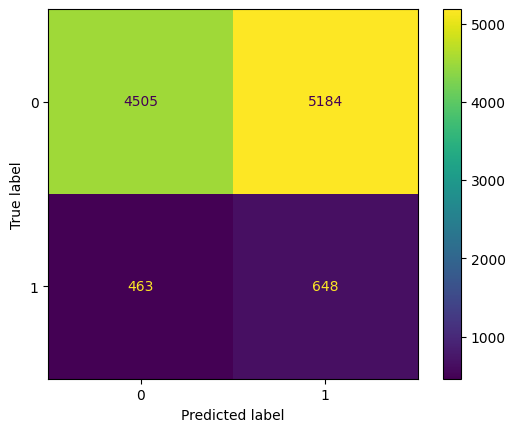

In [24]:
# Observe initial performance of the model without any training
model.eval()
test(model, test_loader, device, config.project_name, save_model = False)
model.train()

In [25]:
# Loss and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor(float(config.pos_weight)).to(dtype=torch.long, device=config.device) * torch.ones([1]).to(config.device))
# criterion = nn.BCEWithLogitsLoss(pos_weight = 5 * torch.ones([1]).to(config.device))

# optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate, betas=(0.9, 0.999),
#                              eps=1e-8, weight_decay=config.weight_decay, amsgrad=False)  
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01,
                             amsgrad=False, maximize=False, foreach=None, capturable=False, 
                             differentiable=False, fused=None)

scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=config.gamma)

print('optimizer: ', optimizer)
print('')
print('loss function: ', criterion)
print('')
print('scheduler', scheduler)
print('')

optimizer:  AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.001
    lr: 0.001
    maximize: False
    weight_decay: 0.01
)

loss function:  BCEWithLogitsLoss()

scheduler <torch.optim.lr_scheduler.ExponentialLR object at 0x7fb688505eb0>



In [26]:
# Train the model
train(model, train_loader, val_loader, criterion, optimizer, scheduler, config)

  0%|          | 0/25 [00:00<?, ?it/s]


 Validation:
              precision    recall  f1-score   support

         0.0       0.91      0.47      0.62      8817
         1.0       0.12      0.61      0.21      1083

    accuracy                           0.48      9900
   macro avg       0.52      0.54      0.41      9900
weighted avg       0.82      0.48      0.57      9900

Epoch [1/25], Step [10/100], Train Loss: 1.2245
learning_rate:  0.001
Train Loss after 10 batches: 1.224
Epoch [1/25], Step [20/100], Train Loss: 1.2235
learning_rate:  0.001
Train Loss after 20 batches: 1.223
Epoch [1/25], Step [30/100], Train Loss: 1.2233
learning_rate:  0.001
Train Loss after 30 batches: 1.223
Epoch [1/25], Step [40/100], Train Loss: 1.1694
learning_rate:  0.001
Train Loss after 40 batches: 1.169
Epoch [1/25], Step [50/100], Train Loss: 1.1552
learning_rate:  0.001
Train Loss after 50 batches: 1.155
Epoch [1/25], Step [60/100], Train Loss: 1.1276
learning_rate:  0.001
Train Loss after 60 batches: 1.128
Epoch [1/25], Step [70/100], 

Accuracy of the model on 10800 transactions in test data: 85.314815%
f1_score_test:  0.5012578616352201
              precision    recall  f1-score   support

         0.0       0.96      0.87      0.91      9687
         1.0       0.39      0.72      0.50      1113

    accuracy                           0.85     10800
   macro avg       0.67      0.79      0.71     10800
weighted avg       0.90      0.85      0.87     10800



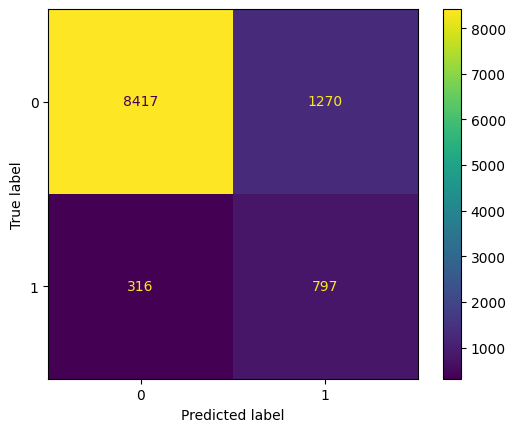

In [27]:
# Test the model -> no need to compute gradients (for memory efficiency)
test(model, test_loader, device, config.project_name, save_model = True)

In [28]:
# Print learnable parameter values after training
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

input_embedding.weight tensor([[ 0.0021,  0.2726,  0.1501,  ..., -0.1496, -0.1056, -0.0765],
        [ 0.2669, -0.2252, -0.2506,  ...,  0.1740,  0.2594,  0.0882],
        [ 0.1301,  0.1836,  0.1049,  ..., -0.0616,  0.0688,  0.0646],
        ...,
        [-0.1037, -0.2203,  0.1484,  ..., -0.1795, -0.2250, -0.1400],
        [-0.2979, -0.1337,  0.0458,  ...,  0.1881, -0.0184, -0.1529],
        [ 0.1631, -0.1515, -0.2128,  ..., -0.2663,  0.0965, -0.1101]],
       device='cuda:0')
position_embedding.weight tensor([[-1.4740e-01, -3.1109e-01,  1.6756e-01,  4.7371e-02, -3.2034e-01,
          1.3223e-01,  1.6921e-01,  4.4159e-02,  1.2460e-02,  1.6204e-01,
         -2.5367e-01,  2.6116e-01, -2.0303e-01, -1.6858e-01,  2.0410e-01,
          9.3142e-02,  2.9821e-01,  4.1964e-03, -1.7384e-01, -1.3079e-01,
         -2.6247e-01,  1.1906e-01, -7.3606e-02, -1.3022e-01,  1.4187e-01,
         -1.4397e-02, -6.0359e-02, -1.6356e-01,  4.1786e-02, -6.8856e-02,
         -1.4135e-01, -2.0822e-01, -5.7330e-02, -

In [29]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
f1_score_test,▁█
f1_score_val,▁▇▇▇▇█████████████████████
learning_rate,██▇▇▆▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test_accuracy,▁█
train_loss,█▄▂▂▃▂▃▂▁▂▂▁▂▁▁▁▂▂▂▁▂▂▁▂▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▁
val_accuracy,▁███▇█████████████████████
epoch,25
f1_score_test,0.50126
f1_score_val,0.51732
learning_rate,2e-05
